In [ ]:
%matplotlib widget

import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".8"

import abtem
import ase
from ase.cluster import Octahedron, Decahedron
from ase.build import bulk, surface
from ase.visualize import view
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import numpy as np

from pathlib import Path
import sys
# add parent folder (and common src folder) to sys.path so imports can be resolved
parent = Path.cwd().parent
candidates = [parent, parent / "src"]
for p in candidates:
    if p.exists() and str(p) not in sys.path:
        sys.path.insert(0, str(p))


from wide_angle_propagation import (
    energy2wavelength, 
    fresnel_propagation_kernel, 
    simulate_fresnel_as,
    simulate_wpm,
    )

abtem.config.set({"device": "cpu"})
abtem.config.set({"precision": "float64"})
jax.config.update("jax_enable_x64", True)


In [2]:
import abtem
from ase.build import bulk, surface
import numpy as np

# 1. Create the base Gold unit cell
au_bulk = bulk('Au', 'fcc', a=4.078)

# 2. Orient to [110] zone axis
# CRITICAL CHANGE: Use layers=2 to capture the full AB stacking sequence of Au(110).
atoms = surface(au_bulk, (1, 1, 0), layers=2)

# 3. Orthogonalize
atoms = abtem.orthogonalize_cell(atoms)

# 4. FIX THE ERROR: Manually define the Z-cell vector
# The periodicity along [110] for FCC is a / sqrt(2).
# We set the 3rd cell vector (index 2,2) to this value.
z_periodicity = 4.078 / np.sqrt(2)
atoms.cell[2, 2] = z_periodicity

# 5. Set Periodic Boundary Conditions to True in all directions (3D Bulk)
atoms.pbc = [True, True, True]

# Check dimensions now (Z should no longer be 0)
print(f"Corrected Base Cell: {atoms.cell.lengths()}")

# --- Tilt the crystal ---
atoms.rotate(0, 'y', rotate_cell=True)

# 6. Make it "Wide" and "Thick"
target_width = 100
target_thickness = 1000

nx = int(np.ceil(target_width / atoms.cell.lengths()[0]))
ny = int(np.ceil(target_width / atoms.cell.lengths()[1]))
nz = int(np.ceil(target_thickness / atoms.cell.lengths()[2]))

# Create the supercell
sample = atoms * (nx, ny, nz)

print(f"Final Sample Dimensions: {sample.cell.lengths()}")
print(f"Number of atoms: {len(sample)}")


Corrected Base Cell: [2.88358145 2.88358145 2.88358145]
Final Sample Dimensions: [ 100.92535088  100.92535088 1000.60276443]
Number of atoms: 850150


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Side view'}, xlabel='x [Å]', ylabel='z [Å]'>)

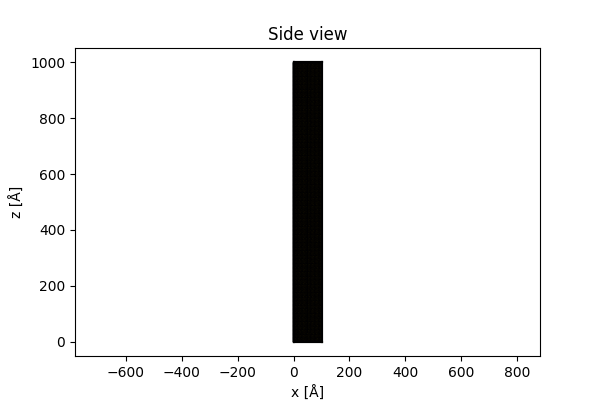

In [3]:
fig, ax1 = plt.subplots(1, 1, figsize=(6, 4))
abtem.show_atoms(sample, plane="xz", ax=ax1, title="Side view")

In [ ]:
energy = 80e3  # 80 keV
# Create the Potential
slice_thickness=2  # Angstrom
# sampling: Grid sampling (dx, dy). 0.05 A is high precision.
potential = abtem.Potential(
    sample, 
    sampling=0.50, 
    slice_thickness=slice_thickness, # 1 Angstrom slices
    parametrization='lobato' # Accurate scattering factors
)

# Define the CBED Probe
probe = abtem.Probe(
    energy=energy,
    semiangle_cutoff=10.0,
    defocus=0,
)

# Match the probe grid to the potential
probe.grid.match(potential)
probe_array = probe.build(lazy=False).array



In [5]:
potential_array = potential.build(lazy=False).array / slice_thickness


In [6]:
wavelength = energy2wavelength(energy)

Text(0.5, 1.0, 'Probe abtem (angle)')

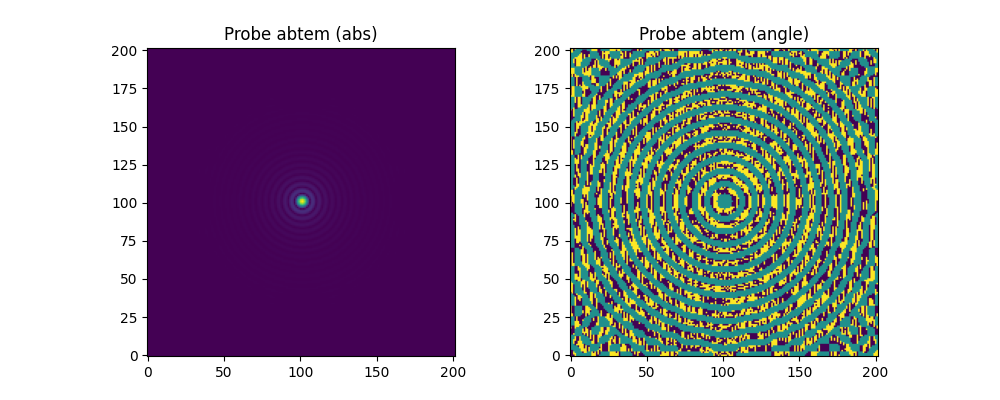

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.imshow(np.abs(probe.build(lazy=False).array), origin='lower')
ax1.set_title('Probe abtem (abs)')
ax2.imshow(np.angle(probe.build(lazy=False).array), origin='lower')
ax2.set_title('Probe abtem (angle)')

In [8]:
# Extract sampling as separate values to ensure proper type handling
sampling_x, sampling_y = probe.grid.sampling[0], probe.grid.sampling[1]

fresnel_propagator = fresnel_propagation_kernel(
    probe.grid.gpts[0],
    probe.grid.gpts[1],
    (sampling_x, sampling_y),  # Pass as tuple explicitly
    z=slice_thickness,
    energy=probe.energy,
)

# Call updated library function with energy and return_wavefronts
exit_wave_fresnel, diffraction_pattern_fresnel, wavefronts_fresnel = simulate_fresnel_as(
    potential_array, probe_array, fresnel_propagator, slice_thickness, 
    energy
)


In [9]:
exit_wave_wpm_binning, diffraction_pattern_wpm_binning, wavefronts_wpm_binning = simulate_wpm(
    potential_array, probe_array, slice_thickness, energy, (sampling_x, sampling_y),
)


## Slice-by-slice Comparison: Fresnel vs WPM binning
The plots below show cross-sections (center row) of the wavefronts for each slice. Intensities are normalized to the same global maximum so differences are directly comparable. Phases are wrapped to [-π, π].


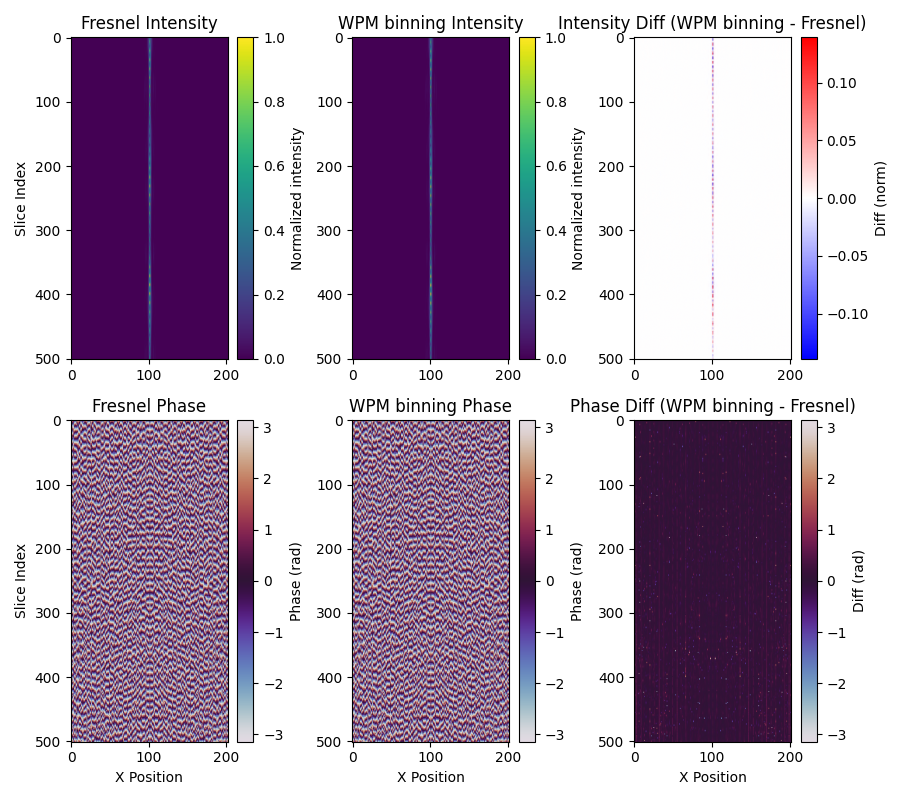

In [10]:
cols = 3
fig, ax = plt.subplots(2, cols, figsize=(cols * 3, 8))

# Use existing cross-section stacks (shape: [slice, x])
wf_fresnel_cs = np.asarray(wavefronts_fresnel)[:, wavefronts_fresnel.shape[1]//2, :]
wf_wpm_bin_cs = np.asarray(wavefronts_wpm_binning)[:, wavefronts_wpm_binning.shape[1]//2, :]

# Intensities
intensity_fresnel = np.abs(wf_fresnel_cs) ** 2
intensity_wpm_bin = np.abs(wf_wpm_bin_cs) ** 2

# Global normalization across the two methods
all_max = max(
    intensity_fresnel.max(),
    intensity_wpm_bin.max(),
)
global_max = all_max if all_max > 0 else 1.0

intensity_fresnel = (intensity_fresnel / global_max).astype(np.float32)
intensity_wpm_bin = (intensity_wpm_bin / global_max).astype(np.float32)

# Intensity difference: WPM binning - Fresnel
intensity_diff = intensity_wpm_bin - intensity_fresnel

# Phases
phase_fresnel = np.angle(wf_fresnel_cs)
phase_wpm_bin = np.angle(wf_wpm_bin_cs)

# Phase difference wrapped to [-pi, pi]
def wrap_phase_diff(a, b):
    return (a - b + np.pi) % (2 * np.pi) - np.pi

phase_diff = wrap_phase_diff(phase_wpm_bin, phase_fresnel)

# Intensity plotting (row 0)
vmax_int = 1.0
im_fresnel = ax[0, 0].imshow(intensity_fresnel, aspect='auto', origin='upper', vmin=0.0, vmax=vmax_int, cmap='viridis')
ax[0, 0].set_title("Fresnel Intensity")
ax[0, 0].set_ylabel("Slice Index")
fig.colorbar(im_fresnel, ax=ax[0, 0], label="Normalized intensity")

im_wpm_bin = ax[0, 1].imshow(intensity_wpm_bin, aspect='auto', origin='upper', vmin=0.0, vmax=vmax_int, cmap='viridis')
ax[0, 1].set_title("WPM binning Intensity")
fig.colorbar(im_wpm_bin, ax=ax[0, 1], label="Normalized intensity")

# Intensity difference colormap limits (symmetric)
vmax_diff = np.max(np.abs(intensity_diff))
vmax_diff = vmax_diff if vmax_diff > 0 else 1.0

im_diff = ax[0, 2].imshow(intensity_diff, aspect='auto', origin='upper', cmap='bwr', vmin=-vmax_diff, vmax=vmax_diff)
ax[0, 2].set_title("Intensity Diff (WPM binning - Fresnel)")
fig.colorbar(im_diff, ax=ax[0, 2], label="Diff (norm)")

# Phase plotting (row 1)
vmin_phase, vmax_phase = -np.pi, np.pi
p_fresnel = ax[1, 0].imshow(phase_fresnel, aspect='auto', origin='upper', cmap='twilight', vmin=vmin_phase, vmax=vmax_phase)
ax[1, 0].set_title("Fresnel Phase")
ax[1, 0].set_xlabel("X Position")
ax[1, 0].set_ylabel("Slice Index")
fig.colorbar(p_fresnel, ax=ax[1, 0], label="Phase (rad)")

p_wpm_bin = ax[1, 1].imshow(phase_wpm_bin, aspect='auto', origin='upper', cmap='twilight', vmin=vmin_phase, vmax=vmax_phase)
ax[1, 1].set_title("WPM binning Phase")
ax[1, 1].set_xlabel("X Position")
fig.colorbar(p_wpm_bin, ax=ax[1, 1], label="Phase (rad)")

# Phase differences
im_diff_phase = ax[1, 2].imshow(phase_diff, aspect='auto', origin='upper', cmap='twilight', vmin=vmin_phase, vmax=vmax_phase)
ax[1, 2].set_title("Phase Diff (WPM binning - Fresnel)")
ax[1, 2].set_xlabel("X Position")
fig.colorbar(im_diff_phase, ax=ax[1, 2], label="Diff (rad)")

plt.tight_layout()



## Exit Wave & Diffraction Pattern: Fresnel vs WPM binning
Exit waves and diffraction patterns are normalized per-image to the range [0,1] for display. Differences use a symmetric diverging colormap.


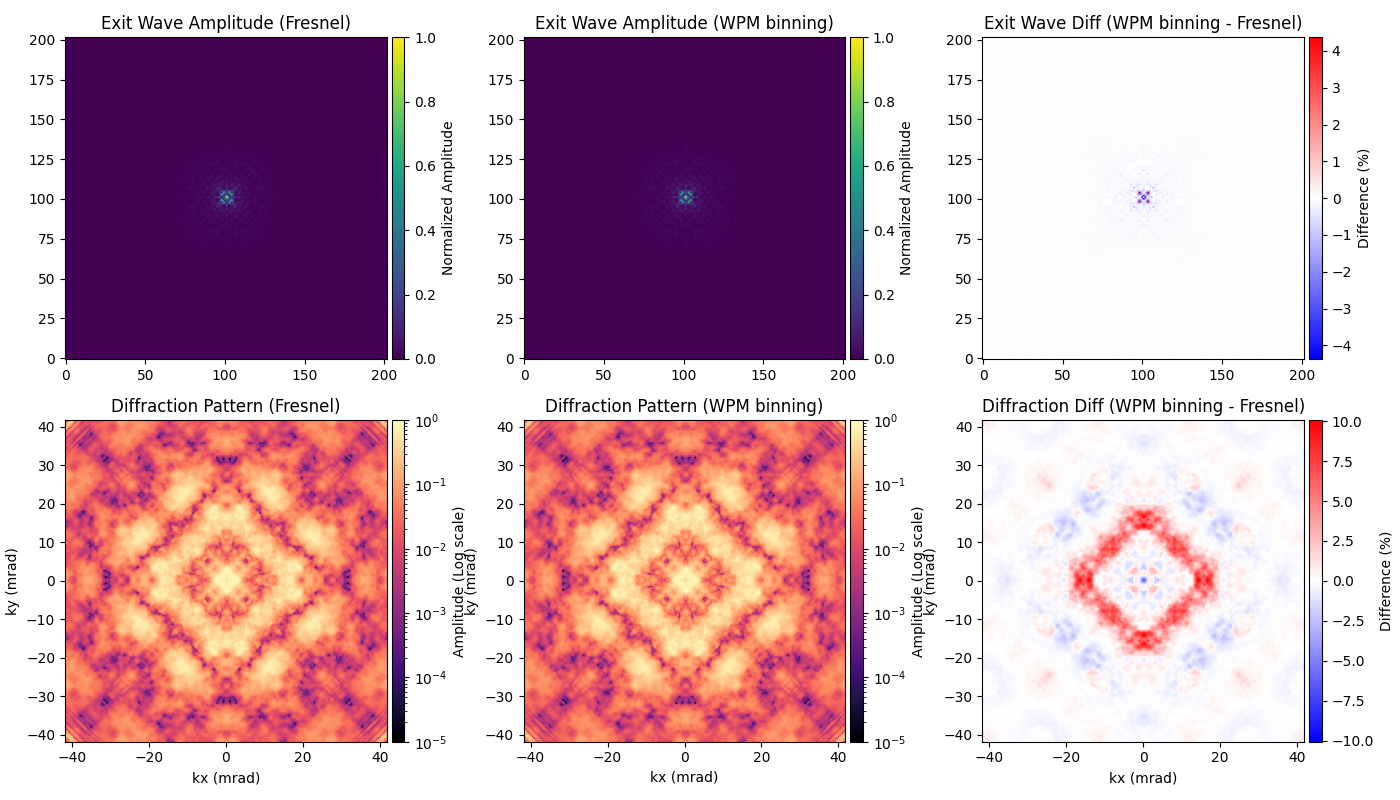

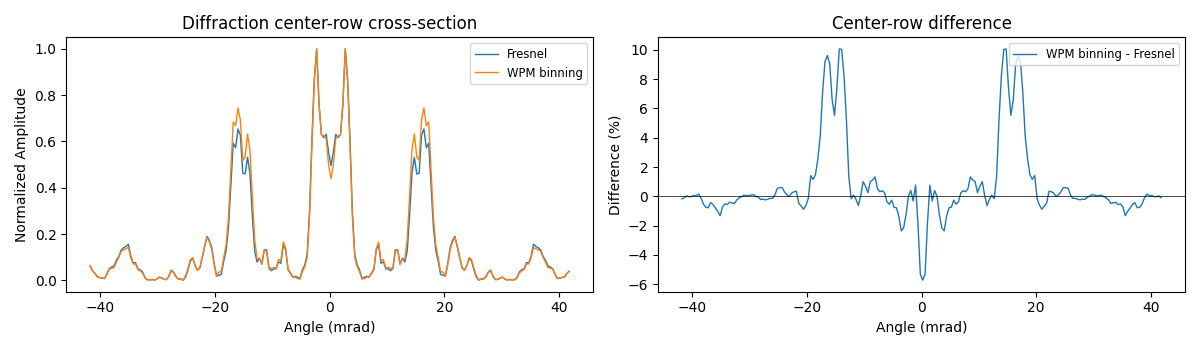

In [11]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm

# helper to fetch available variable names (tries several common names)
def _get(*names):
    for n in names:
        if n in globals():
            return np.asarray(globals()[n])
    raise NameError(f"None of the names found: {names}")

# get wavefronts
ew_f = _get("exit_wave_fresnel", "wf_fresnel", "wavefronts_fresnel")
ew_wb = _get("exit_wave_wpm_binning", "wf_wpm_binning", "wavefronts_wpm_binning")

# get diffraction patterns
dp_f = _get("diffraction_pattern_fresnel", "dp_f")
dp_wb = _get("diffraction_pattern_wpm_binning", "dp_wb")

# layout: 2 rows x 3 columns
fig, axs = plt.subplots(2, 3, figsize=(14, 8))

# colorbar helper
def add_colorbar(ax, im, size="4%", pad=0.05, **kwargs):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size=size, pad=pad)
    return fig.colorbar(im, cax=cax, **kwargs)

# normalize helper
def norm01(x):
    x = np.asarray(x)
    m = x.max() if x.max() != 0 else 1.0
    return (x / m).astype(np.float32)

# --- Row 1: Exit Wave Amplitude (Fresnel, WPM binning, Diff) ---
ew_f_n = norm01(np.abs(ew_f))
ew_wb_n = norm01(np.abs(ew_wb))

diff_ew = (ew_wb_n - ew_f_n) * 100
vmax_ew = np.max(np.abs(diff_ew)) if np.max(np.abs(diff_ew)) > 0 else 1.0

im = axs[0, 0].imshow(ew_f_n, origin='lower', vmin=0.0, vmax=1.0, cmap='viridis')
axs[0, 0].set_title("Exit Wave Amplitude (Fresnel)")
add_colorbar(axs[0, 0], im, label="Normalized Amplitude")

im = axs[0, 1].imshow(ew_wb_n, origin='lower', vmin=0.0, vmax=1.0, cmap='viridis')
axs[0, 1].set_title("Exit Wave Amplitude (WPM binning)")
add_colorbar(axs[0, 1], im, label="Normalized Amplitude")

im = axs[0, 2].imshow(diff_ew, cmap='bwr', origin='lower', vmin=-vmax_ew, vmax=vmax_ew)
axs[0, 2].set_title("Exit Wave Diff (WPM binning - Fresnel)")
add_colorbar(axs[0, 2], im, label="Difference (%)")

# --- Row 2: Diffraction Pattern Amplitude (Fresnel, WPM binning, Diff) ---
# Try to calculate extent in mrad if pixel size and wavelength are available
try:
    ps = probe.grid.sampling[0]
    wl = energy2wavelength(energy)
    # Max scattering angle (semi-angle) in mrad = (lambda / (2 * dx)) * 1000
    theta_max = (float(wl) / (2 * float(ps))) * 1000
    extent = [-theta_max, theta_max, -theta_max, theta_max]
    unit_label = "mrad"
except Exception as e:
    print(f"Could not determine calibration (using pixels): {e}")
    extent = None
    unit_label = "pixels"

dp_f_n = norm01(np.abs(dp_f))
dp_wb_n = norm01(np.abs(dp_wb))

diff_dp = (dp_wb_n - dp_f_n) * 100
vmax_dp = np.max(np.abs(diff_dp)) if np.max(np.abs(diff_dp)) > 0 else 1.0

# Use LogNorm to visualize the high dynamic range of diffraction patterns
# vmin is set to a small value (e.g., 1e-5) to handle the background
im = axs[1, 0].imshow(dp_f_n, origin='lower', norm=LogNorm(vmin=1e-5, vmax=1.0), cmap='magma', extent=extent)
axs[1, 0].set_title("Diffraction Pattern (Fresnel)")
axs[1, 0].set_xlabel(f"kx ({unit_label})")
axs[1, 0].set_ylabel(f"ky ({unit_label})")
add_colorbar(axs[1, 0], im, label="Amplitude (Log scale)")

im = axs[1, 1].imshow(dp_wb_n, origin='lower', norm=LogNorm(vmin=1e-5, vmax=1.0), cmap='magma', extent=extent)
axs[1, 1].set_title("Diffraction Pattern (WPM binning)")
axs[1, 1].set_xlabel(f"kx ({unit_label})")
axs[1, 1].set_ylabel(f"ky ({unit_label})")
add_colorbar(axs[1, 1], im, label="Amplitude (Log scale)")

im = axs[1, 2].imshow(diff_dp, cmap='bwr', origin='lower', vmin=-vmax_dp, vmax=vmax_dp, extent=extent)
axs[1, 2].set_title("Diffraction Diff (WPM binning - Fresnel)")
axs[1, 2].set_xlabel(f"kx ({unit_label})")
axs[1, 2].set_ylabel(f"ky ({unit_label})")
add_colorbar(axs[1, 2], im, label="Difference (%)")

plt.tight_layout()
fig.savefig("fresnel_vs_wpm_2d_maps.pdf", dpi=300)

# --- Additional: Cross-section plot of diffraction patterns and their difference (center row) ---
try:
    center_row = dp_f_n.shape[0] // 2
    if extent is not None:
        x = np.linspace(extent[0], extent[1], dp_f_n.shape[1])
        xlabel_cs = f"Angle ({unit_label})"
    else:
        x = np.arange(dp_f_n.shape[1])
        xlabel_cs = "X pixel"

    fig_cs, ax_cs = plt.subplots(1, 2, figsize=(12, 3.5))

    # center-row profiles
    ax = ax_cs[0]
    ax.plot(x, dp_f_n[center_row, :], label='Fresnel', lw=1)
    ax.plot(x, dp_wb_n[center_row, :], label='WPM binning', lw=1)
    ax.set_title('Diffraction center-row cross-section')
    ax.set_xlabel(xlabel_cs)
    ax.set_ylabel('Normalized Amplitude')
    ax.legend(loc='upper right', fontsize='small')

    # differences
    ax = ax_cs[1]
    ax.plot(x, (dp_wb_n[center_row, :] - dp_f_n[center_row, :]) * 100, label='WPM binning - Fresnel', lw=1)
    ax.axhline(0, color='k', lw=0.5)
    ax.set_title('Center-row difference')
    ax.set_xlabel(xlabel_cs)
    ax.set_ylabel('Difference (%)')
    ax.legend(loc='upper right', fontsize='small')

    plt.tight_layout()
    fig_cs.savefig("fresnel_vs_wpm_cross_sections.pdf", dpi=300)
except Exception as e:
    print("Failed to plot diffraction cross-section:", e)
